## PRECIP 2022 Radars Scans in the Field for Realtime Monitoring

**Realtime CWB image. User-defined azimuth and range.**

* **This notebook pulls the CWB latest radar image from https://www.cwb.gov.tw/V8/C/W/OBS_Radar.html, and plot the scan azimuths from the planned S-Pol (Hsin-Chu) and SEA-POL (Yonaguni Isl.) radar locations.**

* **How to run?**
    1. Choose the radars (S-Pol at Hsin-Chu or SEA-POL at Yonaguni, or both)
    2. Specify the list of the scan azimuths and ranges.
    3. Check out the output figure of the scans.
    4. Repeat 2–3 to make final decision for the scan strategy.


In [1]:
# %reset

In [2]:
import datetime
import pytz
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
from pyproj import Geod
# from PIL import Image

***
#### <font color='red'>! Don't worry about the cells below till the specification section !</font> unless you want to make some further edits.
***

#### Functions for time retrieving:

In [3]:
def timeround10(dt):
    # a, b = divmod(round(dt.minute, -1), 60)
    a, b = divmod(math.floor(dt.minute * 0.1)/0.1, 60)
    # return '%i:%02i' % ((dt.hour + a) % 24, b)
    print(b)
    return datetime.datetime(dt.year, dt.month, dt.day, int((dt.hour + a) % 24), int(b), 0, 0) 

def timeround10before(tm):
    tm = tm - datetime.timedelta(minutes=tm.minute % 10, seconds=tm.second, microseconds=tm.microsecond)
    return tm


#### Retrieve the latest radar image form CWB and generate one test plot:
* Choose between two different CWB map types ('L'arge area / 'C'oncentrate to Taiwan) \
and w/wo topography (wo:1 / w:2).
* The URL for of the latest radar image will be printed for checking.

In [4]:
map_type = 'C'
map_topo = '1'

if ( map_type == 'C' ):
    img_extent = (118, 124, 20.5, 26.5)
elif( map_type == 'L' ):
    img_extent = (115, 126.5, 17.75, 29.25)

def map_selection(map_type, map_topo):
    if ( map_type == 'C' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_TW_3600_'
    elif ( map_type == 'L' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_3600_'
    return radar_img_url_name
        
radar_img_url_name = map_selection(map_type, map_topo)
    
try:
    radar_img_time = timeround10before(datetime.datetime.now(pytz.timezone('Asia/Taipei'))).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)
except:
    print('Current time unavailable. Try 10-min before:')
    radar_time = datetime.datetime.now(pytz.timezone('Asia/Taipei')) - datetime.timedelta(minutes=10)
    radar_img_time = timeround10before(radar_time).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)

# plt.figure(figsize=(4, 4), dpi=150)
# plt.imshow(radar_img)
# plt.show()


/var/folders/8d/7vfq6vq90w341ddvxxt1k4540000gn/T/ipykernel_13688/4070692524.py:21: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  radar_img = plt.imread(radar_img_url)


https://www.cwb.gov.tw/Data/radar/CV1_TW_3600_202206241220.png


#### Function generating maps and azimuth rings:

In [5]:
def new_map(fig, sitename, azimuths_mand, azimuths_user, ranges):
    
    ## Radars locations (lon, lat, rhi range):
    radars_info = { 'SPOL': [120.908, 24.819, 150]#100]
                  , 'SEAPOL': [122.9439, 24.4572, 97]
                  }
    
    ## Create projection centered as the CWB radar image:
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ## Add coastlines:
    ax.coastlines('10m', 'lightgray', linewidth=1, zorder=0)
    
    ## Set extent the same as CWB radar image:
    if ( map_type == 'C' ):
        ax.set_extent([117.75, 124.25, 20.25, 26.75])
    elif ( map_type == 'L' ):
        ax.set_extent([114.75, 126.75, 17.5, 29.5])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     # , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    gl.ylines = False
    if ( map_type == 'L' ):
        gl.xlocator = plticker.FixedLocator(np.arange(115, 126.5, 1))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    ## Add the location of the radar:
    rloc = plt.plot( radars_info[sitename][0], radars_info[sitename][1]
                   , marker='s'
                   , markersize=7
                   , mec='none'
                   , mew=1
                   , mfc='r'
                   , linestyle='none'
                   , transform=ccrs.PlateCarree()
                   , zorder=10
                   , label=sitename
                   )

    ## Set geod:
    geod = Geod(ellps='WGS84')
    
    ## Add radar range rings:
    for rng_km in ranges:
        rrings = ax.tissot( rad_km=rng_km
                          , lons=radars_info[sitename][0]
                          , lats=radars_info[sitename][1]
                          , n_samples=180
                          , facecolor='none'
                          , edgecolor='r'
                          , linewidth=1.2
                          , linestyle='dotted'
                          , label='SUR ranges (km)'
                          )
        lon_r, lat_r, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], 0, rng_km*1e3)
        ax.text(lon_r, lat_r, rng_km, transform=ccrs.PlateCarree(), color='r')
    
    ## Line points at azimuths (mandatory):
    for az in azimuths_mand:
        lon2, lat2, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], az, radars_info[sitename][2]*1e3)
        sazi = ax.plot( [radars_info[sitename][0], lon2]
                      , [radars_info[sitename][1], lat2]
                      , ':k'
                      , transform=ccrs.PlateCarree()
                      , linewidth=0.8
                      , label='RHI azimuths (deg)'
                      )
        ax.text(lon2, lat2, az, transform=ccrs.PlateCarree())
        
    ## Line points at azimuths (user-defined):
    for az in azimuths_user:
        lon2, lat2, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], az, radars_info[sitename][2]*1e3)
        sazi = ax.plot( [radars_info[sitename][0], lon2]
                      , [radars_info[sitename][1], lat2]
                      , '-k'
                      , transform=ccrs.PlateCarree()
                      , linewidth=0.8
                      , label='RHI azimuths (deg)'
                      )
        ax.text(lon2, lat2, az, transform=ccrs.PlateCarree())
        
    # Set legend:
    legend_elements = [Line2D([0], [0], linestyle=':', color='k', lw=1, label='Mandatory'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='RHIuser')]
    plt.legend(handles=legend_elements, loc='center left', shadow=True)
    # plt.legend(loc='lower center'
    #           , shadow=True
    #           )
    
    return ax

***
#### <font color='red'>! Don't worry about the cells above !</font> unless you want to make some further edits.
***

### <font color='forestgreen'>User specifications from here:<font color='darkorange'>
### <font color='darkorange'>1. Choose the radars:</font>
**Keep the radar you want to make the figure and comment the other.**

In [6]:
the_radar = 'SPOL'
# the_radar = 'SEAPOL'
# the_radar = 'both'

### <font color='darkorange'>2. Specify the scans azimuth & ranges:</font>
**Specify the azimuth angles into the list, e.g. 0º for Noth. And scan ranges in [km].**

In [7]:
# Mandatory RHI scan angles (should not modify)
rhi_scan_mandatory = [101, 281, 90, 85, 75, 60, 45, 30, 0, 315, 270, 225, 183, 137]

# Range rings
scan_range = [25, 50, 100, 150]

**User-defined RHIs** [from Spol documentation in Ops Plan]

Can consider centering on specific locations of interest or wider coverage in a specific direction, for example:

- NCU: 3° azimuthal spacing over a 30° sector centered near NCU at 60° azimuth (angles = 42.0°, 45.0°,48.0°, 51.0°, 54.0°, 57.0°, 60.0°, 63.0°, 66.0°, 69.0°, 72.0°, 75.0°)
- TEAM-R: located at 29° azimuth
- full360: 15, 345, 330, 298, 255, 240, 211, 197, 168, 153, 125, 113
- North sector: 290, 300, 310, 320, 330, 340, 350, 10, 20, 37, 52, 67
- East sector: 10, 20, 37, 52, 67, 110, 120, 130, 145, 155, 165, 175
- South sector: 255, 240, 215, 205, 195, 175, 165, 155, 145, 130, 120, 110
- West sector: 350, 340, 330, 320, 310, 300, 290, 255, 240, 215, 205, 195
- Preset sectors: pre-set NE, NW, SE, and SW quadrants
- Problematic azimuthal angles to avoid: 29.0°, 135.0°, 180.0°, 70-74° (too close to Wufenshan radar/interference)
- Recommendation to order the RHIs so the end angle is the one closest to 101° (the start angle for mandatory RHI1) 


In [8]:
# Specify PrecipRhiUser

# Either using one of the standard sector setups:

RHIusername='360'

if RHIusername == '360':
    rhi_scan_user = [15, 345, 330, 298, 255, 240, 211, 197, 168, 153, 125, 113]
elif RHIusername == 'north':
    rhi_scan_user = [290, 300, 310, 320, 330, 340, 350, 10, 20, 37, 52, 67]
elif RHIusername == 'east':
    rhi_scan_user = [10, 20, 37, 52, 67, 110, 120, 130, 145, 155, 165, 175]
elif RHIusername == 'south':
    rhi_scan_user = [255, 240, 215, 205, 195, 175, 165, 155, 145, 130, 120, 110]
elif RHIusername == 'west':
    rhi_scan_user = [350, 340, 330, 320, 310, 300, 290, 255, 240, 215, 205, 195]

# Or customize it:
# south and east:
# rhi_scan_user = [345, 330, 298, 255, 237, 212, 197, 193, 188, 178, 173, 168]
# mostly east:
# rhi_scan_user = [330, 298, 211, 197, 168, 153, 125, 113, 107, 95, 80, 67.5]

# "INITIATION" scan pattern: south and east sectors for afternoon development
rhi_scan_user = [211, 203, 195, 189, 177, 171, 125, 113, 107, 95, 80, 67.5]

# GPM overpass
# rhi_scan_user = [22.1, 25.1, 28.1, 208.1, 205.1, 202.1]

# Dummy checks
# Ensure we've picked 12 angles
if np.shape(rhi_scan_user)[0] != 12: print("Check number of angles!")
# Avoid problematic angles
azim_avoid = [29,135,180]
for iaz in azim_avoid:
    if iaz in rhi_scan_user: print("STOP: check for bad azimuth!")
# Range from 70-74 must also be avoided
if np.any(np.logical_and(np.array(rhi_scan_user) >= 70, np.array(rhi_scan_user) <= 74)):
    print("STOP: check for bad azimuth!")

### <font color='darkorange'>3. Check out the figure:</font>
**The figure of desired radar scans will be generated here and saved as a png file under the same folder.**

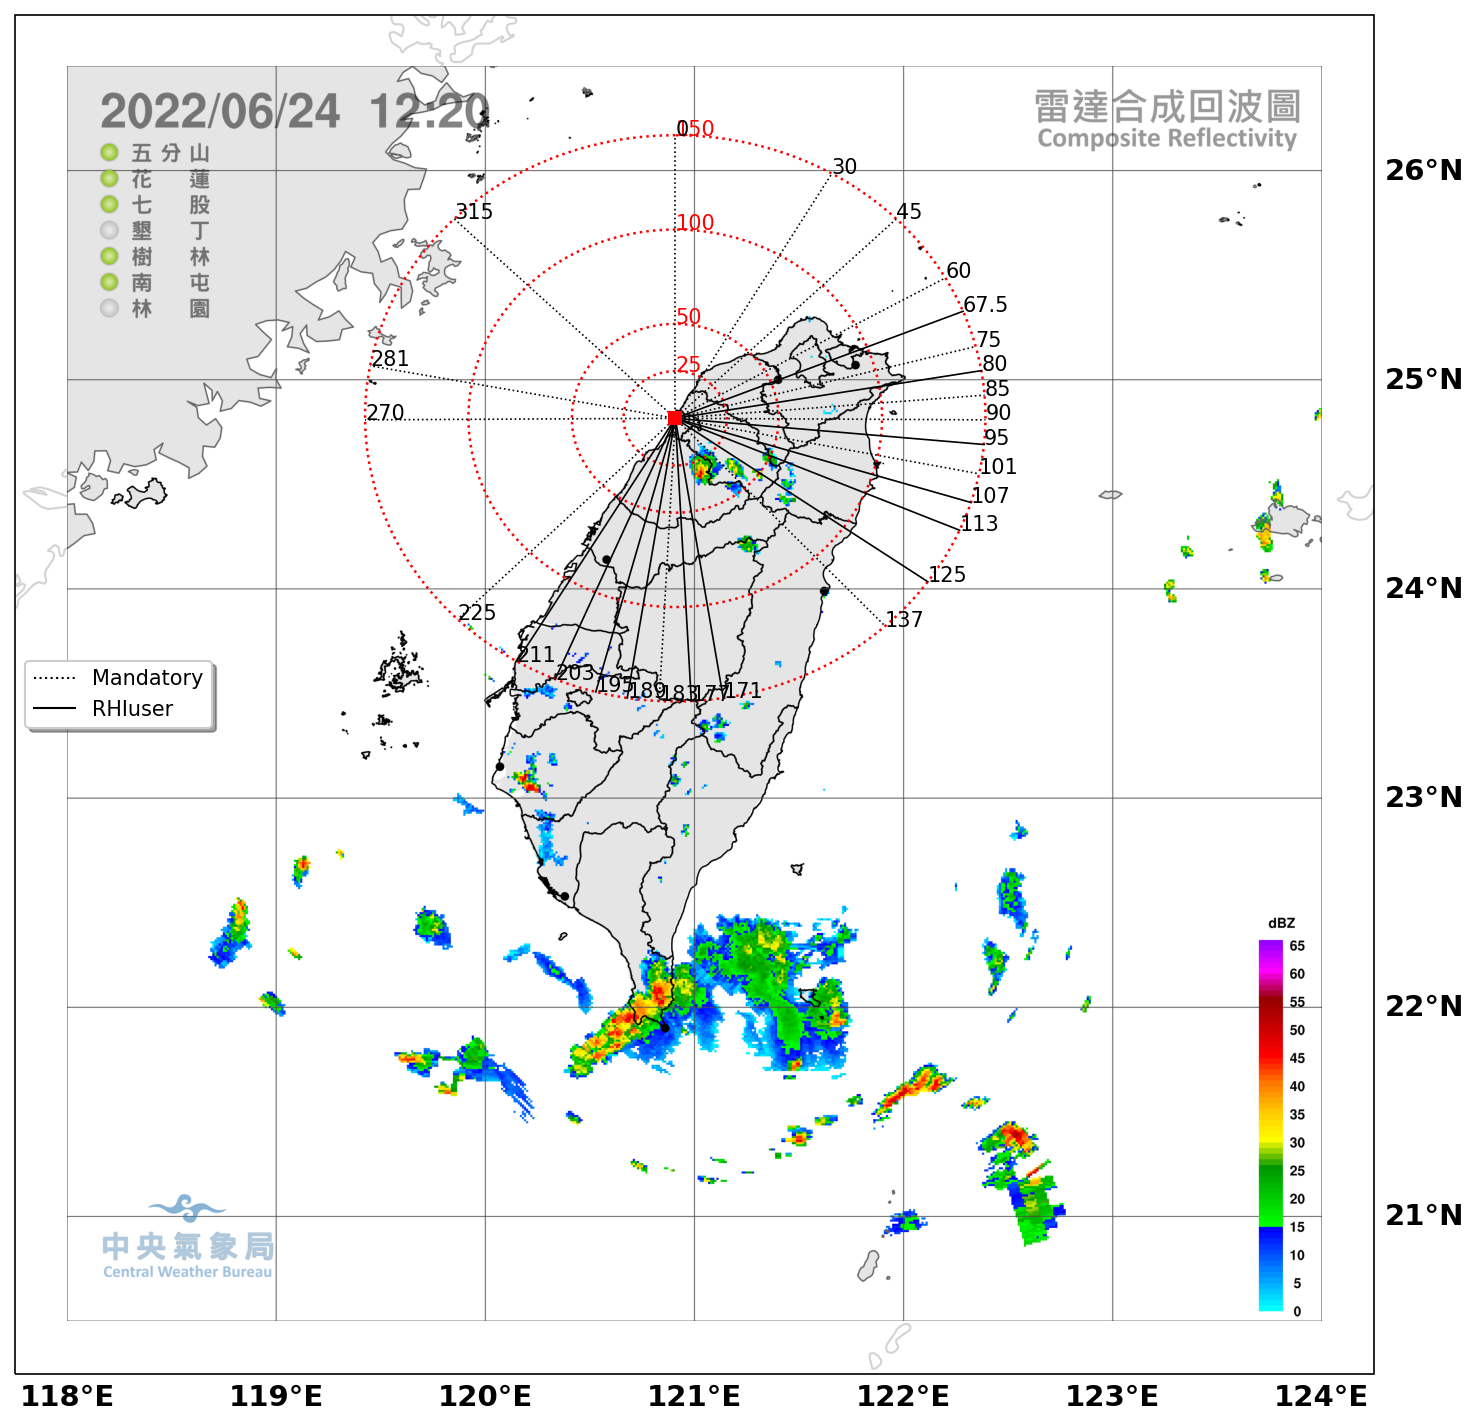

In [11]:
fig = plt.figure(figsize=(12, 12), dpi=150)

# ax = new_map(fig, the_radar, rhi_scans, scan_range)
ax = new_map(fig, the_radar, rhi_scan_mandatory, rhi_scan_user, scan_range)
plt.imshow(radar_img, extent=img_extent, zorder=0, transform=ccrs.PlateCarree())

plt.savefig('./PRECIP2022_' + the_radar + '_scans.png', bbox_inches='tight')

In [10]:
# # Estimating the GPM overpass:
# a = 6371. # km
# dlon = 3. # deg
# dlat = 5.8
# dx = a*dlon*np.pi/180. * np.cos(25.*np.pi/180.)
# dy = a*dlat*np.pi/180.
# print('dx = ',dx)
# print('dy = ',dy)
# angle = (np.arctan(dx/dy) * 180./np.pi)
# print('RHI1 = ',angle)
# print('RHI2 = ',angle+180)